# Starbucks Capstone Challenge
Notebook 2 of 4

### Principal Components Analysis

Now that our data is preprocessed into dataframes of numerical features, we are ready to begin a PCA to reduce the dimensions. Standard practice is to run the PCA with n-1 dimensions, which is what we will do here. The results of our PCA wiill be inputs into our k-means clustering of customer segments which will be the 2nd half of this notebook. 

In [1]:
import pandas as pd
import numpy as np
import math
from IPython.display import display, HTML

import matplotlib.pyplot as plt
import matplotlib
#% matplotlib inline

prefix = 'preprocessed_data'

def import_csvs(prefix, filename):
    df = pd.read_csv(prefix + filename)
    df.index = df['id']
    df = df.drop(columns ='id')    
    return df
    
male_customers = import_csvs(prefix,'/male.csv')
female_customers = import_csvs(prefix,'/female.csv')

print("male_customers: {} rows and {} columns".format(male_customers.shape[0],male_customers.shape[1]))
print("female_customers: {} rows and {} columns".format(female_customers.shape[0],female_customers.shape[1]))

male_customers: 8295 rows and 5 columns
female_customers: 5993 rows and 5 columns


Before continuing, we must **normalize** all of the data by scaling every value to fall on a range from 0-1 for each column. 

In [2]:
display(HTML(male_customers.iloc[0:5].to_html()))

,age,income,age of account,num purchases,amount per purchase
id,,,,,
e2127556f4f64592b11af22de27a7932,68,70,2,3,19.243333
389bc3fa690240e798340f5a15918d5c,65,53,5,3,12.143333
2eeac8d8feae4a8cad5a6af0499a211d,58,51,8,4,3.905000
e12aeaf2d47d42479ea1c4ac3d8286c6,26,46,53,11,5.110909
62cf5e10845442329191fc246e7bcea3,49,52,44,9,16.012222


In [3]:
# scale numerical features into a normalized range, 0-1
from sklearn.preprocessing import MinMaxScaler

def normalize_df(df):
    scaler=MinMaxScaler()
    df_scaled = pd.DataFrame(scaler.fit_transform(df.astype(float)))
    df_scaled.columns=df.columns
    df_scaled.index=df.index
    return df_scaled

In [4]:
male_scaled = normalize_df(male_customers)
female_scaled = normalize_df(female_customers)

female_scaled.head()

,age,income,age of account,num purchases,amount per purchase
id,,,,,
0610b486422d4921ae7d2bf64640c50b,0.445783,0.911111,0.203390,0.066667,0.056357
78afa995795e4d85b5d9ceeca43f5fef,0.686747,0.777778,0.237288,0.200000,0.049892
aa4862eba776480b8bb9c68455b8c2e1,0.518072,0.300000,0.169492,0.166667,0.031067
31dda685af34476cad5bc968bdb01c53,0.530120,0.455556,0.491525,0.233333,0.043861
a448667f336b42c9a66fc5ffd5d73772,0.518072,0.111111,0.033898,0.200000,0.006047


Let's get the **roles and buckets** needed for our PCA model.

In [5]:
# sagemaker libraries
import boto3
import sagemaker
from sagemaker import get_execution_role

session = sagemaker.Session() # store the current SageMaker session
role = get_execution_role()# get IAM role
bucket_name = session.default_bucket()# get default bucket

To run our model, we'll need to **upload the data to s3**.

In [6]:
prefix_male = 'male_customers'
prefix_female = 'female_customers'
output_path_male ='s3://{}/{}/'.format(bucket_name, prefix_male)
output_path_female ='s3://{}/{}/'.format(bucket_name, prefix_female)
print('Training artifacts will be uploaded to: \n{}\n{}'.format(output_path_male, output_path_female))

Training artifacts will be uploaded to: 
s3://sagemaker-us-east-2-794135268543/male_customers/
s3://sagemaker-us-east-2-794135268543/female_customers/


In [7]:
from sagemaker import PCA

#current features - 1
N_COMPONENTS=4

Now we can build and train our 2 models. 

In [8]:
pca_SM_male = PCA(role=role,
             train_instance_count=1,
             train_instance_type='ml.c4.xlarge',
             output_path=output_path_male, # specified, above
             num_components=N_COMPONENTS, 
             sagemaker_session=session)

In [9]:
pca_SM_female = PCA(role=role,
             train_instance_count=1,
             train_instance_type='ml.c4.xlarge',
             output_path=output_path_female, # specified, above
             num_components=N_COMPONENTS, 
             sagemaker_session=session)

In [10]:
# convert df to np array
male_train_data_np = male_scaled.values.astype('float32')
female_train_data_np = female_scaled.values.astype('float32')

# convert to RecordSet format
formatted_male_train_data = pca_SM_male.record_set(male_train_data_np)
formatted_female_train_data = pca_SM_female.record_set(female_train_data_np)

Now our data is properly formatted, uploaded to s3, and our models are ready. We can go ahead and train them.

In [11]:
%%time

# train the PCA mode on the formatted data
pca_SM_male.fit(formatted_male_train_data)

2020-05-16 18:12:41 Starting - Starting the training job...
2020-05-16 18:12:42 Starting - Launching requested ML instances......
2020-05-16 18:13:47 Starting - Preparing the instances for training...
2020-05-16 18:14:24 Downloading - Downloading input data...
2020-05-16 18:15:03 Training - Downloading the training image..Docker entrypoint called with argument(s): train
Running default environment configuration script
[05/16/2020 18:15:22 INFO 139995464951616] Reading default configuration from /opt/amazon/lib/python2.7/site-packages/algorithm/resources/default-conf.json: {u'_num_gpus': u'auto', u'_log_level': u'info', u'subtract_mean': u'true', u'force_dense': u'true', u'epochs': 1, u'algorithm_mode': u'regular', u'extra_components': u'-1', u'_kvstore': u'dist_sync', u'_num_kv_servers': u'auto'}
[05/16/2020 18:15:22 INFO 139995464951616] Reading provided configuration from /opt/ml/input/config/hyperparameters.json: {u'feature_dim': u'5', u'mini_batch_size': u'500', u'num_components': 

In [12]:
%%time

# train the PCA mode on the formatted data
pca_SM_female.fit(formatted_female_train_data)

2020-05-16 18:15:53 Starting - Starting the training job...
2020-05-16 18:15:54 Starting - Launching requested ML instances......
2020-05-16 18:16:57 Starting - Preparing the instances for training......
2020-05-16 18:18:15 Downloading - Downloading input data
2020-05-16 18:18:15 Training - Downloading the training image...
2020-05-16 18:18:46 Uploading - Uploading generated training model
2020-05-16 18:18:46 Completed - Training job completed
Docker entrypoint called with argument(s): train
Running default environment configuration script
[05/16/2020 18:18:37 INFO 139774167705408] Reading default configuration from /opt/amazon/lib/python2.7/site-packages/algorithm/resources/default-conf.json: {u'_num_gpus': u'auto', u'_log_level': u'info', u'subtract_mean': u'true', u'force_dense': u'true', u'epochs': 1, u'algorithm_mode': u'regular', u'extra_components': u'-1', u'_kvstore': u'dist_sync', u'_num_kv_servers': u'auto'}
[05/16/2020 18:18:37 INFO 139774167705408] Reading provided configur

Next we'll **unzip** the model and load in the results.

In [13]:
import os 
import mxnet as mx

#copy and paste from a specific job in the AWS console
male_training_job_name='pca-2020-05-13-12-47-14-078'
female_training_job_name='pca-2020-05-13-12-50-25-709'

# where the model is saved, by default
male_model_key = os.path.join(prefix_male, male_training_job_name, 'output/model.tar.gz')

# download and unzip model
boto3.resource('s3').Bucket(bucket_name).download_file(male_model_key, 'model.tar.gz')

# unzipping as model_algo-1
os.system('tar -zxvf model.tar.gz')
os.system('unzip model_algo-1')

# loading the unzipped artifacts
male_pca_model_params = mx.ndarray.load('model_algo-1')

In [14]:
female_model_key = os.path.join(prefix_female, female_training_job_name, 'output/model.tar.gz')
boto3.resource('s3').Bucket(bucket_name).download_file(female_model_key, 'model.tar.gz')

# unzipping as model_algo-1
os.system('tar -zxvf model.tar.gz')
os.system('unzip model_algo-1')
female_pca_model_params = mx.ndarray.load('model_algo-1')

### PCA Model Attributes
Three types of model attributes are contained within the PCA model.

* **mean**: The mean that was subtracted in order to center it.
* **v**: The makeup of the principal components; (same as ‘components_’ in an sklearn PCA model).
* **s**: The singular values of the components for the PCA transformation.
    
We will only use v and s. 

From s, we can get an approximation of the data variance that is covered in the first `n` principal components. The approximate explained variance is given by the formula:

\begin{equation*}
\frac{\sum_{n}^{ } s_n^2}{\sum s^2}
\end{equation*}
 
From v, we can learn more about the combinations of original features that make up each principal component.

In [15]:
def explained_variance(s, n_top_components):
    '''Calculates the approx. data variance that n_top_components captures.
       :param s: A dataframe of singular values for top components; 
           the top value is in the last row.
       :param n_top_components: An integer, the number of top components to use.
       :return: The expected data variance covered by the n_top_components.'''
    
    start_idx = N_COMPONENTS - n_top_components  ## 33-3 = 30, for example
    # calculate approx variance
    exp_variance = np.square(s.iloc[start_idx:,:]).sum()/np.square(s).sum()
    
    return exp_variance[0]

In [16]:
s_male=pd.DataFrame(male_pca_model_params['s'].asnumpy())
v_male=pd.DataFrame(male_pca_model_params['v'].asnumpy())
s_female=pd.DataFrame(female_pca_model_params['s'].asnumpy())
v_female=pd.DataFrame(female_pca_model_params['v'].asnumpy())

In [17]:
n_top_components = 3 # select a value for the number of top components

# calculate the explained variance
male_exp_variance = explained_variance(s_male, n_top_components)
female_exp_variance = explained_variance(s_female, n_top_components)
print('Explained variance for male for {} components: {}'.format(n_top_components, male_exp_variance))
print('Explained variance for female for {} components: {}'.format(n_top_components, female_exp_variance))

Explained variance for male for 3 components: 0.9171463847160339
Explained variance for female for 3 components: 0.9087642431259155


For 2 components we see around 70% variance explained, with 3 components it is 90%, and with all 4 components it is 100%. For our purposes, we will proceed with 3 components as that provides the best tradeoff in dimensionality and variance.

# Component Makeup
It will be helpful to visualize the components to see what the weighting is of the original features in each component.

In [18]:
male_features_list = male_scaled.columns.values
female_features_list = female_scaled.columns.values
print('Features: \n', male_features_list)

Features: 
 ['age' 'income' 'age of account' 'num purchases' 'amount per purchase']


In [19]:
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib

def display_component(v, features_list, component_num, n_weights=3, gender = ['male','female']):
    
    # get index of component (last row - component_num)
    row_idx = N_COMPONENTS-component_num

    # get the list of weights from a row in each df of v
    v_1_row = v[0].iloc[:, row_idx]
    v_1 = np.squeeze(v_1_row.values)
    v_2_row = v[1].iloc[:, row_idx]
    v_2 = np.squeeze(v_2_row.values)   

    # match weights to features in counties_scaled dataframe, using list comporehension
    comps_1 = pd.DataFrame(list(zip(v_1, features_list[0])), 
                         columns=['weights', 'male_features'])
    comps_2 = pd.DataFrame(list(zip(v_2, features_list[1])), 
                         columns=['weights', 'female_features'])

    # we'll want to sort by the largest n_weights
    # weights can be neg/pos and we'll sort by magnitude
    comps_1['abs_weights']=comps_1['weights'].apply(lambda x: np.abs(x))
    comps_2['abs_weights']=comps_2['weights'].apply(lambda x: np.abs(x))
    
    sorted_weight_data_1 = comps_1.sort_values('abs_weights', ascending=False).head(n_weights)
    sorted_weight_data_2 = comps_2.sort_values('abs_weights', ascending=False).head(n_weights)
    #print(sorted_weight_data_1)
    %matplotlib inline 
    # display using seaborn
    ax=plt.subplots(figsize=(16,6))
    
    ax=plt.subplot(2, 2, 1)
    ax=sns.barplot(data=sorted_weight_data_1, 
                   x="weights", 
                   y="male_features", 
                   palette="Blues_d")
    ax.set_title("PCA Component Makeup - " + gender[0] + ", Component #" + str(component_num))    
    
    ax=plt.subplot(2, 2, 2)
    ax=sns.barplot(data=sorted_weight_data_2, 
               x="weights", 
               y="female_features", 
               palette="Blues_d")
    ax.set_title("PCA Component Makeup - " + gender[1] + ", Component #" + str(component_num))
    #plt.subplots_adjust(hspace = 1.5)
    plt.subplots_adjust(wspace = .5)
    plt.show()

### Component Makeup by Gender
Let's graph the components side-by-side to compare the results for each gender. 

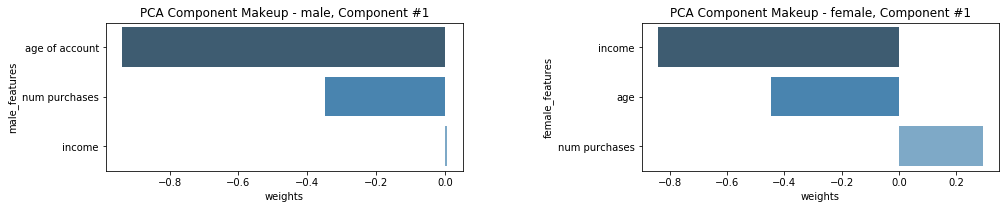

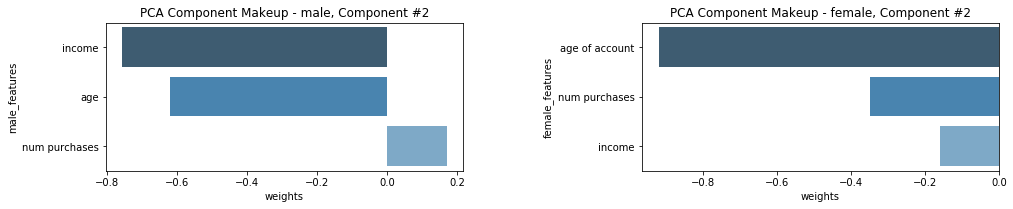

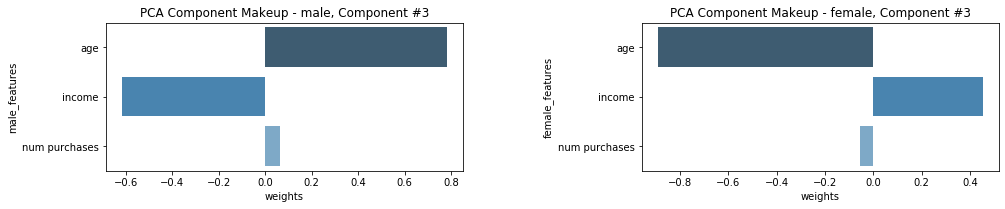

In [20]:
gender_list = ['male', 'female']
v_list = [v_male, v_female]
scaled_list = [male_scaled.columns.values, female_scaled.columns.values]
for i in range(len(male_features_list)-2):
    display_component(v_list, scaled_list, component_num=i+1, n_weights=3, gender = gender_list)

Interestingly, there are some similarities yet also some differences. The 1st male component and 2nd female component are somewhat similar but not the same. Likewise, the 1st female component and the 2nd male component are similar but not the same. The similarities are not enough for us to remove gender as a variable from our data, especially since we have not yet compared their reactions to promotions (which will be done later in the linear regression step). 

In [21]:
#Difference in explained variance between 1st and 2nd components
#n_top_components = 1 # select a value for the number of top components
# calculate the explained variance
for n_top_components in [1,2]:
    male_exp_variance = explained_variance(s_male, n_top_components)
    female_exp_variance = explained_variance(s_female, n_top_components)
    print('Explained variance for male for {} components: {}'.format(n_top_components, male_exp_variance))
    print('Explained variance for female for {} components: {}'.format(n_top_components, female_exp_variance))


Explained variance for male for 1 components: 0.3829598128795624
Explained variance for female for 1 components: 0.43561238050460815
Explained variance for male for 2 components: 0.7262885570526123
Explained variance for female for 2 components: 0.7137019634246826


In addition to the 1st and 2nd components have minor differences in the weights, they also have differences in the explained variance.

### Deploy Model
Next we'll deploy our model and pass in our training data to get a transformed dataframe to use in our customer segmentation.

In [22]:
%%time
# this takes a little while, around 7mins
pca_predictor_male = pca_SM_male.deploy(initial_instance_count=1, 
                              instance_type='ml.t2.medium')

-----------------!CPU times: user 299 ms, sys: 19.2 ms, total: 318 ms
Wall time: 8min 32s


In [23]:
male_train_pca = pca_predictor_male.predict(male_train_data_np)
# check out the first item in the produced training features
data_idx = 0
print(male_train_pca[data_idx])

label {
  key: "projection"
  value {
    float32_tensor {
      values: -0.03399546444416046
      values: 0.08655960857868195
      values: -0.2094820737838745
      values: 0.2983003556728363
    }
  }
}



In [24]:
# create dimensionality-reduced data
def create_transformed_df(train_pca, df_scaled, n_top_components):
    ''' Return a dataframe of data points with component features. 
        The dataframe should be indexed by State-County and contain component values.
        :param train_pca: A list of pca training data, returned by a PCA model.
        :param counties_scaled: A dataframe of normalized, original features.
        :param n_top_components: An integer, the number of top components to use.
        :return: A dataframe, indexed by State-County, with n_top_component values as columns.        
     '''
    # create new dataframe to add data to
    df_transformed=pd.DataFrame()

    # for each of our new, transformed data points
    # append the component values to the dataframe
    for data in train_pca:
        # get component values for each data point
        components=data.label['projection'].float32_tensor.values
        df_transformed=df_transformed.append([list(components)])

    # index by county, just like counties_scaled
    df_transformed.index=df_scaled.index

    # keep only the top n components
    start_idx = N_COMPONENTS - n_top_components
    df_transformed = df_transformed.iloc[:,start_idx:]
    
    # reverse columns, component order     
    return df_transformed.iloc[:, ::-1]
    

In [25]:
# specify top n
top_n = 3

# call function and create a new dataframe
male_transformed = create_transformed_df(male_train_pca, male_scaled, n_top_components=top_n)

# add descriptive columns
PCA_list=['c_1', 'c_2', 'c_3']
male_transformed.columns=PCA_list 

# print result
male_transformed.head()

,c_1,c_2,c_3
id,,,
e2127556f4f64592b11af22de27a7932,0.298300,-0.209482,0.086560
389bc3fa690240e798340f5a15918d5c,0.249573,-0.044962,0.174136
2eeac8d8feae4a8cad5a6af0499a211d,0.192009,0.028753,0.122874
e12aeaf2d47d42479ea1c4ac3d8286c6,-0.592181,0.295599,-0.158024
62cf5e10845442329191fc246e7bcea3,-0.429457,0.068360,0.019166


In [26]:
# delete predictor endpoint
session.delete_endpoint(pca_predictor_male.endpoint)

Let's run the same process with the female data

In [27]:
%%time
# this takes a little while, around 7mins
pca_predictor_female = pca_SM_female.deploy(initial_instance_count=1, 
                              instance_type='ml.t2.medium')

-----------------------------------------------------!CPU times: user 809 ms, sys: 34 ms, total: 843 ms
Wall time: 26min 34s


In [28]:
female_train_pca = pca_predictor_female.predict(female_train_data_np)
# check out the first item in the produced training features
data_idx = 0
print(female_train_pca[data_idx])

# call function and create a new dataframe
female_transformed = create_transformed_df(female_train_pca, female_scaled, n_top_components=top_n)

# add descriptive columns
female_transformed.columns=PCA_list 

# print result
female_transformed.head()

label {
  key: "projection"
  value {
    float32_tensor {
      values: 0.017244622111320496
      values: 0.24087567627429962
      values: 0.06192860007286072
      values: -0.42594367265701294
    }
  }
}



,c_1,c_2,c_3
id,,,
0610b486422d4921ae7d2bf64640c50b,-0.425944,0.061929,0.240876
78afa995795e4d85b5d9ceeca43f5fef,-0.379519,-0.010614,-0.041087
aa4862eba776480b8bb9c68455b8c2e1,0.084332,0.151140,-0.105657
31dda685af34476cad5bc968bdb01c53,-0.011242,-0.194475,-0.047215
a448667f336b42c9a66fc5ffd5d73772,0.245243,0.294826,-0.194390


In [29]:
# delete predictor endpoint
session.delete_endpoint(pca_predictor_female.endpoint)

# Customer Segmentation
Now that we have completed the PCA step, we can cluster our customers. To do this, we will define a **k-means model**. This is an unsupervised algorithm that will identify similarities across our 3 components and cluster our customers into specific segments. In addition to running the model, we must identify what the best value is for 'k' as that will determine our segments.

In [33]:
from sagemaker import KMeans
from time import gmtime, strftime

output_time = strftime("%Y-%m-%d-%H-%M-%S", gmtime())
output_folder = 'kmeans-lowlevel-' + output_time
K = range(2, 6) # 6 as a maximum to limit results to boost interpretability
instance_count = 1

# jobs for all k
for k in K:
    print('starting train job:' + str(k))        
    female_kmeans = KMeans(role=role,
                train_instance_count=1,
                train_instance_type='ml.c4.xlarge',
                output_path=output_path_female + '{}/'.format(str(k)),             
                k=k)

    # convert the transformed dataframe into record_set data
    female_kmeans_train_data_np = female_transformed.values.astype('float32')
    female_kmeans_formatted_data = female_kmeans.record_set(train = female_kmeans_train_data_np)    
    
    female_kmeans.fit(female_kmeans_formatted_data)

starting train job:2
2020-05-16 19:06:51 Starting - Starting the training job...
2020-05-16 19:06:53 Starting - Launching requested ML instances......
2020-05-16 19:07:56 Starting - Preparing the instances for training...
2020-05-16 19:08:47 Downloading - Downloading input data......
2020-05-16 19:09:49 Training - Training image download completed. Training in progress.
2020-05-16 19:09:49 Uploading - Uploading generated training model
2020-05-16 19:09:49 Completed - Training job completed
Docker entrypoint called with argument(s): train
Running default environment configuration script
[05/16/2020 19:09:40 INFO 139737394964288] Reading default configuration from /opt/amazon/lib/python2.7/site-packages/algorithm/resources/default-input.json: {u'_enable_profiler': u'false', u'_tuning_objective_metric': u'', u'_num_gpus': u'auto', u'local_lloyd_num_trials': u'auto', u'_log_level': u'info', u'_kvstore': u'auto', u'local_lloyd_init_method': u'kmeans++', u'force_dense': u'true', u'epochs': u

Model for k=2 (female_customers/2/kmeans-2020-05-13-14-47-12-977/output/model.tar.gz)
model_algo-1
state_5db3a134-4e3d-4143-97b6-25451a6889be
Model for k=3 (female_customers/3/kmeans-2020-05-13-14-50-55-374/output/model.tar.gz)
state_5af38330-84a6-48dc-9d91-810a7ac86315
model_algo-1
Model for k=4 (female_customers/4/kmeans-2020-05-13-14-54-37-636/output/model.tar.gz)
state_e87e9b77-08a3-48eb-95aa-164fcd380482
model_algo-1
Model for k=5 (female_customers/5/kmeans-2020-05-13-14-58-20-944/output/model.tar.gz)
state_cfb81b4a-4886-4a58-9171-26c06c56a13f
model_algo-1


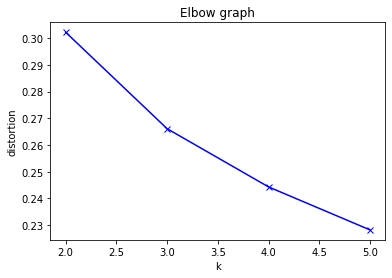

In [34]:
from scipy.spatial.distance import cdist

plt.plot()
colors = ['b', 'g', 'r']
markers = ['o', 'v', 's']
models = {}
distortions = []

outputs = ['s3://sagemaker-us-east-2-794135268543/female_customers/2/kmeans-2020-05-13-14-47-12-977/output/model.tar.gz',
           's3://sagemaker-us-east-2-794135268543/female_customers/3/kmeans-2020-05-13-14-50-55-374/output/model.tar.gz',
           's3://sagemaker-us-east-2-794135268543/female_customers/4/kmeans-2020-05-13-14-54-37-636/output/model.tar.gz',
           's3://sagemaker-us-east-2-794135268543/female_customers/5/kmeans-2020-05-13-14-58-20-944/output/model.tar.gz']

keys = ['female_customers/2/kmeans-2020-05-13-14-47-12-977/output/model.tar.gz',
           'female_customers/3/kmeans-2020-05-13-14-50-55-374/output/model.tar.gz',
           'female_customers/4/kmeans-2020-05-13-14-54-37-636/output/model.tar.gz',
           'female_customers/5/kmeans-2020-05-13-14-58-20-944/output/model.tar.gz']

for k,key in zip(K,keys):
    s3_client = boto3.client('s3')
    #key = '/female_customers/' + '{}/'.format(str(k)) + j + '/output/model.tar.gz' #female_customers/2/kmeans-2020-05-13-14-47-12-977/output
    #key = 'kmeans_example/output/' + output_folder +'/' + output_folder + str(k) + '/output/model.tar.gz'
    s3_client.download_file(bucket_name, key, 'model.tar.gz')
    print("Model for k={} ({})".format(k, key))
    !tar -xvf model.tar.gz                       
    kmeans_model=mx.ndarray.load('model_algo-1')
    kmeans_numpy = kmeans_model[0].asnumpy()
    distortions.append(sum(np.min(cdist(female_transformed, kmeans_numpy, 'euclidean'), axis=1)) / female_transformed.shape[0])
    models[k] = kmeans_numpy
 
# Plot the elbow
plt.plot(K, distortions, 'bx-')
plt.xlabel('k')
plt.ylabel('distortion')
plt.title('Elbow graph')
plt.show()

It looks like our values for K were not large enough, so let's run some more models with larger values for k.

In [35]:
K = range(6, 10) # 10 as a maximum to limit results to boost interpretability
instance_count = 1

for k in K:
    print('starting train job:' + str(k))        
    female_kmeans = KMeans(role=role,
                train_instance_count=1,
                train_instance_type='ml.c4.xlarge',
                output_path=output_path_female + '{}/'.format(str(k)),             
                k=k)

    # convert the transformed dataframe into record_set data
    female_kmeans_train_data_np = female_transformed.values.astype('float32')
    female_kmeans_formatted_data = female_kmeans.record_set(female_kmeans_train_data_np)    
    
    female_kmeans.fit(female_kmeans_formatted_data)

starting train job:6
2020-05-16 19:20:40 Starting - Starting the training job...
2020-05-16 19:20:42 Starting - Launching requested ML instances.........
2020-05-16 19:22:13 Starting - Preparing the instances for training......
2020-05-16 19:23:28 Downloading - Downloading input data...
2020-05-16 19:24:11 Training - Training image download completed. Training in progress.
2020-05-16 19:24:11 Uploading - Uploading generated training model.Docker entrypoint called with argument(s): train
Running default environment configuration script
[05/16/2020 19:24:08 INFO 140601251657536] Reading default configuration from /opt/amazon/lib/python2.7/site-packages/algorithm/resources/default-input.json: {u'_enable_profiler': u'false', u'_tuning_objective_metric': u'', u'_num_gpus': u'auto', u'local_lloyd_num_trials': u'auto', u'_log_level': u'info', u'_kvstore': u'auto', u'local_lloyd_init_method': u'kmeans++', u'force_dense': u'true', u'epochs': u'1', u'init_method': u'random', u'local_lloyd_tol': 

Model for k=2 (female_customers/2/kmeans-2020-05-13-14-47-12-977/output/model.tar.gz)
model_algo-1
state_5db3a134-4e3d-4143-97b6-25451a6889be
Model for k=3 (female_customers/3/kmeans-2020-05-13-14-50-55-374/output/model.tar.gz)
state_5af38330-84a6-48dc-9d91-810a7ac86315
model_algo-1
Model for k=4 (female_customers/4/kmeans-2020-05-13-14-54-37-636/output/model.tar.gz)
state_e87e9b77-08a3-48eb-95aa-164fcd380482
model_algo-1
Model for k=5 (female_customers/5/kmeans-2020-05-13-14-58-20-944/output/model.tar.gz)
state_cfb81b4a-4886-4a58-9171-26c06c56a13f
model_algo-1
Model for k=6 (female_customers/6/kmeans-2020-05-13-15-28-44-351/output/model.tar.gz)
model_algo-1
state_14feb4e5-bf0e-4dd6-9731-79292672791c
Model for k=7 (female_customers/7/kmeans-2020-05-13-15-32-26-771/output/model.tar.gz)
model_algo-1
state_87f2af4c-f8a2-4e1b-aade-10929d6abe89
Model for k=8 (female_customers/8/kmeans-2020-05-13-15-36-09-062/output/model.tar.gz)
state_8aaf50aa-1618-49a5-903f-e9d09d7cb9b9
model_algo-1
Model 

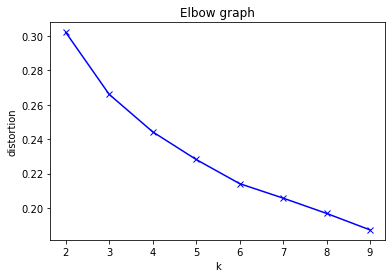

In [36]:
plt.plot()
colors = ['b', 'g', 'r']
markers = ['o', 'v', 's']
models = {}
distortions = []

keys = ['female_customers/2/kmeans-2020-05-13-14-47-12-977/output/model.tar.gz',
           'female_customers/3/kmeans-2020-05-13-14-50-55-374/output/model.tar.gz',
           'female_customers/4/kmeans-2020-05-13-14-54-37-636/output/model.tar.gz',
           'female_customers/5/kmeans-2020-05-13-14-58-20-944/output/model.tar.gz',
           'female_customers/6/kmeans-2020-05-13-15-28-44-351/output/model.tar.gz',
           'female_customers/7/kmeans-2020-05-13-15-32-26-771/output/model.tar.gz',
           'female_customers/8/kmeans-2020-05-13-15-36-09-062/output/model.tar.gz',
           'female_customers/9/kmeans-2020-05-13-15-39-51-212/output/model.tar.gz']
K = range(2,10)
for k,key in zip(K,keys):
    s3_client = boto3.client('s3')
    #key = '/female_customers/' + '{}/'.format(str(k)) + j + '/output/model.tar.gz' #female_customers/2/kmeans-2020-05-13-14-47-12-977/output
    #key = 'kmeans_example/output/' + output_folder +'/' + output_folder + str(k) + '/output/model.tar.gz'
    s3_client.download_file(bucket_name, key, 'model.tar.gz')
    print("Model for k={} ({})".format(k, key))
    !tar -xvf model.tar.gz                       
    kmeans_model=mx.ndarray.load('model_algo-1')
    kmeans_numpy = kmeans_model[0].asnumpy()
    distortions.append(sum(np.min(cdist(female_transformed, kmeans_numpy, 'euclidean'), axis=1)) / female_transformed.shape[0])
    models[k] = kmeans_numpy
 
# Plot the elbow
plt.plot(K, distortions, 'bx-')
plt.xlabel('k')
plt.ylabel('distortion')
plt.title('Elbow graph')
plt.show()

At **k=6** we see a bit of an inflection point. We will use k=6 for our model.

In [37]:
k = 6
male_kmeans = KMeans(role=role,
                train_instance_count=1,
                train_instance_type='ml.c4.xlarge',
                output_path=output_path_male + '{}/'.format(str(k)),             
                k=k)

# convert the transformed dataframe into record_set data
male_kmeans_train_data_np = male_transformed.values.astype('float32')
male_kmeans_formatted_data = male_kmeans.record_set(male_kmeans_train_data_np)    

male_kmeans.fit(male_kmeans_formatted_data)

2020-05-16 19:36:02 Starting - Starting the training job...
2020-05-16 19:36:03 Starting - Launching requested ML instances......
2020-05-16 19:37:32 Starting - Preparing the instances for training.........
2020-05-16 19:39:02 Downloading - Downloading input data
2020-05-16 19:39:02 Training - Downloading the training image...
2020-05-16 19:39:28 Uploading - Uploading generated training model
2020-05-16 19:39:28 Completed - Training job completed
Docker entrypoint called with argument(s): train
Running default environment configuration script
[05/16/2020 19:39:19 INFO 140712374159168] Reading default configuration from /opt/amazon/lib/python2.7/site-packages/algorithm/resources/default-input.json: {u'_enable_profiler': u'false', u'_tuning_objective_metric': u'', u'_num_gpus': u'auto', u'local_lloyd_num_trials': u'auto', u'_log_level': u'info', u'_kvstore': u'auto', u'local_lloyd_init_method': u'kmeans++', u'force_dense': u'true', u'epochs': u'1', u'init_method': u'random', u'local_lloy

In [38]:
%%time
# deploy the model to create a predictor
male_kmeans_predictor = male_kmeans.deploy(initial_instance_count=1, 
                                 instance_type='ml.t2.medium')

-----------------!CPU times: user 311 ms, sys: 4.62 ms, total: 315 ms
Wall time: 8min 32s


In [39]:
# get the predicted clusters for all the kmeans training data
male_cluster_info=male_kmeans_predictor.predict(male_kmeans_train_data_np)
male_cluster_labels = [c.label['closest_cluster'].float32_tensor.values[0] for c in male_cluster_info]
male_cluster_df = pd.DataFrame(male_cluster_labels)[0].value_counts()
#View distribution of clusters
print(male_cluster_df)

2.0    1875
0.0    1864
5.0    1461
1.0    1121
4.0    1096
3.0     878
Name: 0, dtype: int64


In [40]:
# delete kmeans endpoint
session.delete_endpoint(male_kmeans_predictor.endpoint)

### Model attributes

In [41]:
# download and unzip the kmeans model file
male_model_key = 'male_customers/6/kmeans-2020-05-13-15-50-25-500/output/model.tar.gz'

# download the model file
boto3.resource('s3').Bucket(bucket_name).download_file(male_model_key, 'model.tar.gz')
os.system('tar -zxvf model.tar.gz')
os.system('unzip model_algo-1')

male_kmeans_model_params = mx.ndarray.load('model_algo-1')

print(male_kmeans_model_params)

# get all the centroids
male_cluster_centroids=pd.DataFrame(male_kmeans_model_params[0].asnumpy())
male_cluster_centroids.columns=male_transformed.columns

display(male_cluster_centroids)

[
[[ 0.12168763  0.27804592 -0.12484832]
 [ 0.00916167 -0.41582668 -0.14343618]
 [-0.2296111  -0.12980902  0.05374248]
 [ 0.18102582 -0.13902986 -0.04554396]
 [ 0.15872929  0.07632631  0.19448003]
 [-0.47849745  0.13885881 -0.00845752]]
<NDArray 6x3 @cpu(0)>]


,c_1,c_2,c_3
0,0.121688,0.278046,-0.124848
1,0.009162,-0.415827,-0.143436
2,-0.229611,-0.129809,0.053742
3,0.181026,-0.139030,-0.045544
4,0.158729,0.076326,0.194480
5,-0.478497,0.138859,-0.008458


### Visualize centroids with heatmap

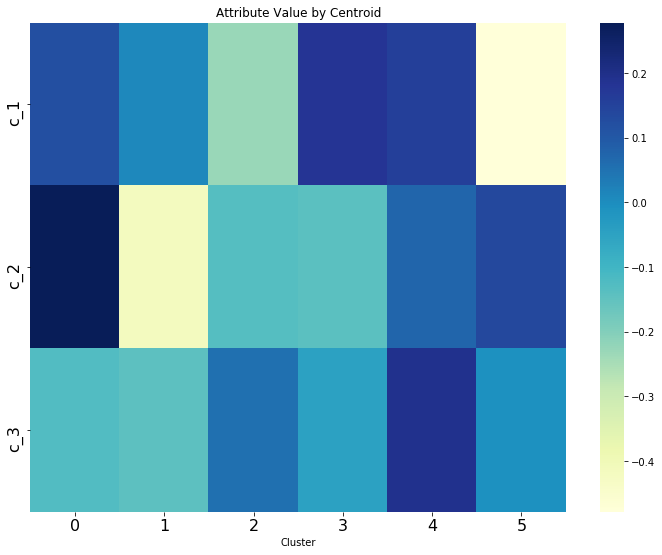

In [42]:
# generate a heatmap in component space, using the seaborn library
plt.figure(figsize = (12,9))
ax = sns.heatmap(male_cluster_centroids.T, cmap = 'YlGnBu')
ax.set_xlabel("Cluster")
plt.yticks(fontsize = 16)
plt.xticks(fontsize = 16)
ax.set_title("Attribute Value by Centroid")
plt.show()

### Natural Groupings

In [43]:
# add a 'labels' column to the dataframe
male_transformed['labels']=list(map(int, male_cluster_labels))

# sort by cluster label 0-6
sorted_male = male_transformed.sort_values('labels', ascending=True)
# view some pts in cluster 0
sorted_male.head(5)

,c_1,c_2,c_3,labels
id,,,,
d53ea893dd774977ad75280d4be4c621,0.154218,0.177039,0.027152,0
02dd040b77914163b1fd02efc3976d55,0.113542,0.147166,-0.126302,0
0a03ef333feb47db93bf30d6ef41b239,0.260916,0.268767,0.079016,0
0d3451dbd862480caf1f408154c18887,0.317323,0.363301,-0.134879,0
c8c5b06729f04e4f81759c605d839658,0.130141,0.316091,-0.009710,0


In [44]:
male_cluster=male_transformed[male_transformed['labels']==1]
male_cluster.head()

,c_1,c_2,c_3,labels
id,,,,
5917d13f6fa04286abdf95f4d5cefb1e,-0.464664,-0.449253,-0.115596,1
9fa9ae8f57894cc9a3b8a9bbe0fc1b2f,-0.233732,-0.221924,-0.338291,1
11da2f066d3943699d10b61fd276fd1a,-0.152819,-0.232465,-0.215134,1
c74beaa959a742309ba8350b7d472676,-0.206050,-0.259251,-0.308168,1
2204f8ff966f48db90246bd7b5918a7f,-0.110986,-0.195777,0.094061,1


### Last Step
That's the last step for the analysis. Now we simply process and join the male and female sets into our final customer segmentation dataset.

In [45]:
k = 6
female_kmeans = KMeans(role=role,
                train_instance_count=1,
                train_instance_type='ml.c4.xlarge',
                output_path=output_path_female + '{}/'.format(str(k)),             
                k=k)

# convert the transformed dataframe into record_set data
female_kmeans_train_data_np = female_transformed.values.astype('float32')
female_kmeans_formatted_data = female_kmeans.record_set(female_kmeans_train_data_np)    

female_kmeans.fit(female_kmeans_formatted_data)

2020-05-16 19:48:18 Starting - Starting the training job...
2020-05-16 19:48:20 Starting - Launching requested ML instances.........
2020-05-16 19:49:50 Starting - Preparing the instances for training...
2020-05-16 19:50:46 Downloading - Downloading input data...
2020-05-16 19:51:18 Training - Downloading the training image..
2020-05-16 19:51:44 Uploading - Uploading generated training model
2020-05-16 19:51:44 Completed - Training job completed
Docker entrypoint called with argument(s): train
Running default environment configuration script
[05/16/2020 19:51:34 INFO 139660500174656] Reading default configuration from /opt/amazon/lib/python2.7/site-packages/algorithm/resources/default-input.json: {u'_enable_profiler': u'false', u'_tuning_objective_metric': u'', u'_num_gpus': u'auto', u'local_lloyd_num_trials': u'auto', u'_log_level': u'info', u'_kvstore': u'auto', u'local_lloyd_init_method': u'kmeans++', u'force_dense': u'true', u'epochs': u'1', u'init_method': u'random', u'local_lloyd

In [46]:
%%time
# deploy the model to create a predictor
female_kmeans_predictor = female_kmeans.deploy(initial_instance_count=1, 
                                 instance_type='ml.t2.medium')

---------------!CPU times: user 275 ms, sys: 13.1 ms, total: 288 ms
Wall time: 7min 31s


In [47]:
# get the predicted clusters for all the kmeans training data
female_cluster_info=female_kmeans_predictor.predict(female_kmeans_train_data_np)
female_cluster_labels = [c.label['closest_cluster'].float32_tensor.values[0] for c in female_cluster_info]
female_cluster_df = pd.DataFrame(female_cluster_labels)[0].value_counts()
#View distribution of clusters
print(female_cluster_df)

1.0    1159
3.0    1145
2.0    1125
4.0    1013
0.0     789
5.0     762
Name: 0, dtype: int64


In [48]:
female_transformed['labels']=list(map(int, female_cluster_labels))

In [49]:
# delete kmeans endpoint
session.delete_endpoint(female_kmeans_predictor.endpoint)

In [50]:
#offset by k so that male and female segments remain distinct in order to be combined
female_transformed['labels']=female_transformed['labels']+k

In [51]:
customer_segments = pd.concat([male_transformed,female_transformed])
customer_segments = customer_segments.drop(columns = ['c_1','c_2','c_3'])
customer_segments.head(5)

,labels
id,
e2127556f4f64592b11af22de27a7932,5
389bc3fa690240e798340f5a15918d5c,2
2eeac8d8feae4a8cad5a6af0499a211d,2
e12aeaf2d47d42479ea1c4ac3d8286c6,4
62cf5e10845442329191fc246e7bcea3,4


In [52]:
customers = pd.concat([male_customers,female_customers])
customers = customers.merge(customer_segments,left_index=True, right_index=True)
customers = customers.rename(columns={'labels': 'customer_segment'})
customers.head(5)

,age,income,age of account,num purchases,amount per purchase,customer_segment
id,,,,,,
e2127556f4f64592b11af22de27a7932,68,70,2,3,19.243333,5
389bc3fa690240e798340f5a15918d5c,65,53,5,3,12.143333,2
2eeac8d8feae4a8cad5a6af0499a211d,58,51,8,4,3.905000,2
e12aeaf2d47d42479ea1c4ac3d8286c6,26,46,53,11,5.110909,4
62cf5e10845442329191fc246e7bcea3,49,52,44,9,16.012222,4


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f6f38a6e860>]],
      dtype=object)

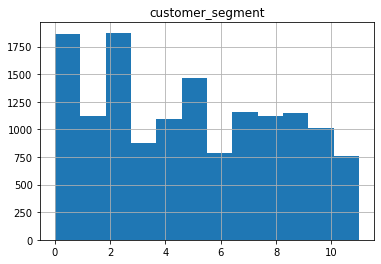

In [53]:
customers.hist(column='customer_segment', bins=12)

And that's it. We now have our customer data segmented into 12 different groups, with each group ranging from just under 500 to ~1800 customers. Let's save it locally for the next notebook and then proceed to Notebook #3.

In [54]:
import os

def make_csv(df, filename, data_dir):
    '''Merges features and labels and converts them into one csv file with labels in the first column.
       :param x: Data features
       :param y: Data labels
       :param file_name: Name of csv file, ex. 'train.csv'
       :param data_dir: The directory where files will be saved
       '''
    # make data dir, if it does not exist
    if not os.path.exists(data_dir):
        os.makedirs(data_dir)

    df.to_csv(os.path.join(data_dir, filename), header=True, index=True)  
    
    # nothing is returned, but a print statement indicates that the function has run
    print('Path created: '+str(data_dir)+'/'+str(filename))

In [55]:
data_dir = 'segmentation_data'
make_csv(customers,'customers.csv',data_dir)    

Path created: segmentation_data/customers.csv


That concludes the Customer Segmentation notebook. The next notebook is further processing of promotions data to prepare for linear regression.